#Name: Shubham Bakde
#B K Birla College of Arts, Science and Commerce

#Super Store Forecasting Model using ARIMA

##1 Reading and understanding the dataset

In [ ]:
!pip install --upgrade xlrd #Installing the xlrd to read our dataset which is in xls formaat
!pip install prophet #Installing Prophet to use it later for forecasting our model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#We try to import evrything in one shell even though we do not import all at once we import everything as we go
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams as rcp
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [ ]:
ss = pd.read_excel("/content/SuperstoreData.xls") #Reading the Dataset
print(ss.head()) #Printing the top 5 rows of our dataset

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10

In [ ]:
ss.shape #Finding total of (Rows, Columns) in our dataset

(9994, 21)

In [ ]:
ss.describe() #Getting Discrete satatistics for our dataset

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [ ]:
ss.info() #Getting info as coloumn types and finding null values in them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [ ]:
ss.dtypes #only to get datatypes for our column

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [ ]:
ss.isnull().sum() #Finding total of null values in our dataset

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

##2 Furniture Sales and Prediction

In [ ]:
#Creating a sample dataset named furniture in which our data will be only having data of furniture category of all affected columns
furniture = ss.loc[ss['Category'] == 'Furniture']
furniture["Order Date"].min(), furniture["Order Date"].max() #Finding the first and last date of order in our dataset which is vital for timeseries prediction

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [ ]:
#Creating a list of column names that we do not require for predictions
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True) #dropping unwanted columns
furniture = furniture.sort_values("Order Date") #sorting our values according to order date for better line graph 
furniture.isnull().sum() #finding null values if any

Order Date    0
Sales         0
Quantity      0
dtype: int64

In [ ]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index() #grouping the dataset to orderdate and sales
furniture = furniture.set_index("Order Date") #resetting the index in furniture dataset to orderdate
furniture.index #printing the index to verify it has changed to order dates

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [ ]:
y = furniture['Sales'].resample('MS').mean() #resampling the dataset to sales mean
print(y["2017":]) #printing the sales data after year 2017

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64


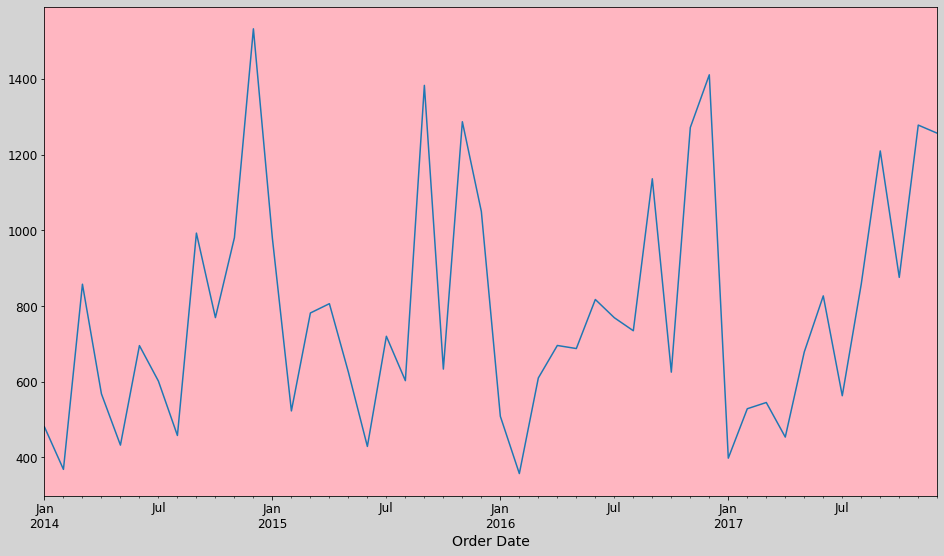

In [ ]:
#Plotting our Sales by Year
plt.figure(facecolor='lightgray')
y.plot(figsize = (16,9))
ax=plt.axes()
ax.set_facecolor('lightpink')
plt.show()

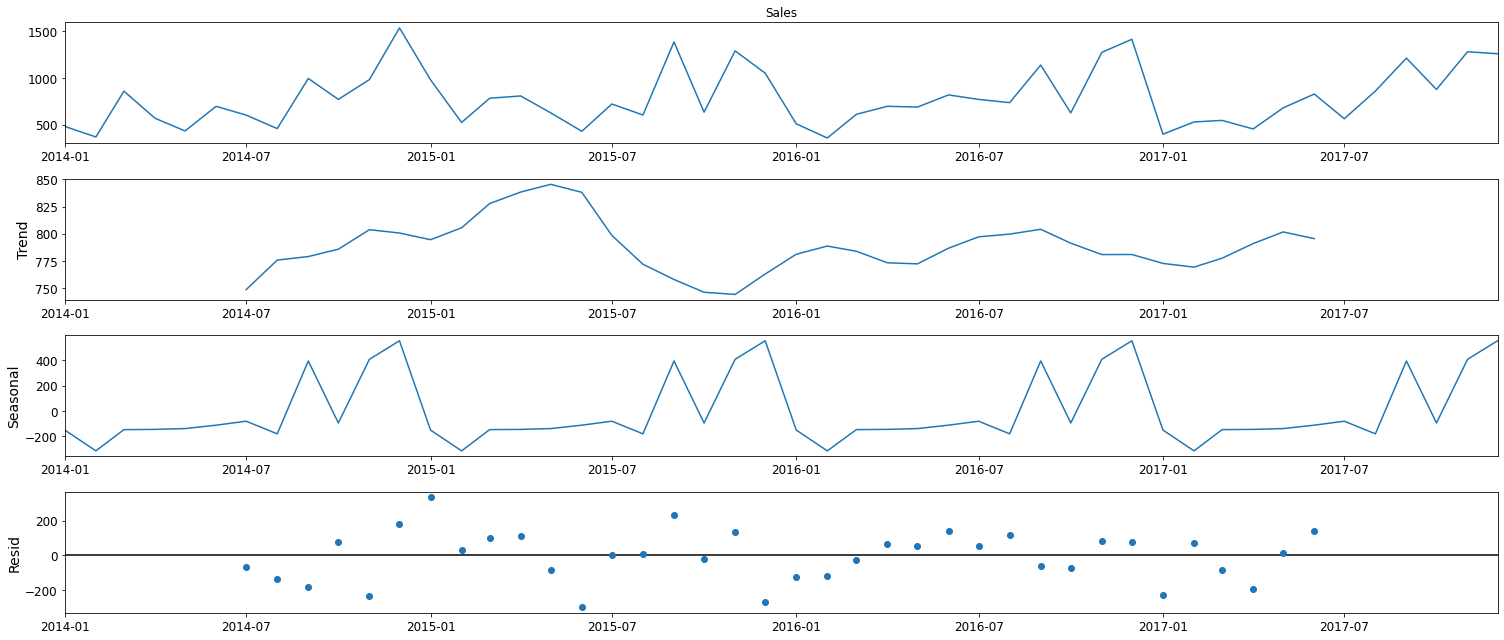

In [ ]:
#Using rcParams to get Seasonal trends in our dataset to find patterns
rcp['figure.figsize'] = 21, 9
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig= decomposition.plot()
plt.show()

##3 Building the SARIMAX and getting ARIMA model

In [ ]:
#Creating Matrix format for SARIMAX
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

In [ ]:
#Printing in form of Matrix in presentaation of our model
print('Examples of paramtere combinations for Seasonal ARIMA...')
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[3]))
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[4]))

Examples of paramtere combinations for Seasonal ARIMA...
SARIMAX:(0, 0, 1) x (0, 0, 1, 12)
SARIMAX:(0, 0, 1) x (0, 1, 0, 12)
SARIMAX:(0, 0, 1) x (0, 1, 1, 12)
SARIMAX:(0, 0, 1) x (1, 0, 0, 12)


In [ ]:
#Finding best combination in our model through ARIMA value
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal, enforce_stationary = False, enforce_invertibility = False)
      results = mod.fit()
      print("ARIMA{} x {}12 - AIC:{}".format(param,param_seasonal, results.aic))
    except:
      continue

mod = sm.tsa.statespace.SARIMAX(y, order = (1,1,1), seasonal_order = (1,1,0,12), enforce_stationary = False, enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])

ARIMA(0, 0, 0) x (0, 0, 0, 12)12 - AIC:784.7193402038779
ARIMA(0, 0, 0) x (0, 0, 1, 12)12 - AIC:1578.9705438668952
ARIMA(0, 0, 0) x (0, 1, 0, 12)12 - AIC:495.37090274829427
ARIMA(0, 0, 0) x (0, 1, 1, 12)12 - AIC:489.83053264640563
ARIMA(0, 0, 0) x (1, 0, 0, 12)12 - AIC:691.7786646571428
ARIMA(0, 0, 0) x (1, 0, 1, 12)12 - AIC:1816.465402295854
ARIMA(0, 0, 0) x (1, 1, 0, 12)12 - AIC:491.2539819426996
ARIMA(0, 0, 0) x (1, 1, 1, 12)12 - AIC:491.8095630481389
ARIMA(0, 0, 1) x (0, 0, 0, 12)12 - AIC:751.0635462763048
ARIMA(0, 0, 1) x (0, 0, 1, 12)12 - AIC:1897.9725407523122
ARIMA(0, 0, 1) x (0, 1, 0, 12)12 - AIC:497.04455587194275
ARIMA(0, 0, 1) x (0, 1, 1, 12)12 - AIC:491.6640771286905
ARIMA(0, 0, 1) x (1, 0, 0, 12)12 - AIC:689.6572888677722
ARIMA(0, 0, 1) x (1, 0, 1, 12)12 - AIC:1827.973792960293
ARIMA(0, 0, 1) x (1, 1, 0, 12)12 - AIC:493.19798657859
ARIMA(0, 0, 1) x (1, 1, 1, 12)12 - AIC:493.6293522353216
ARIMA(0, 1, 0) x (0, 0, 0, 12)12 - AIC:691.6686053842182
ARIMA(0, 1, 0) x (0, 0, 1, 1

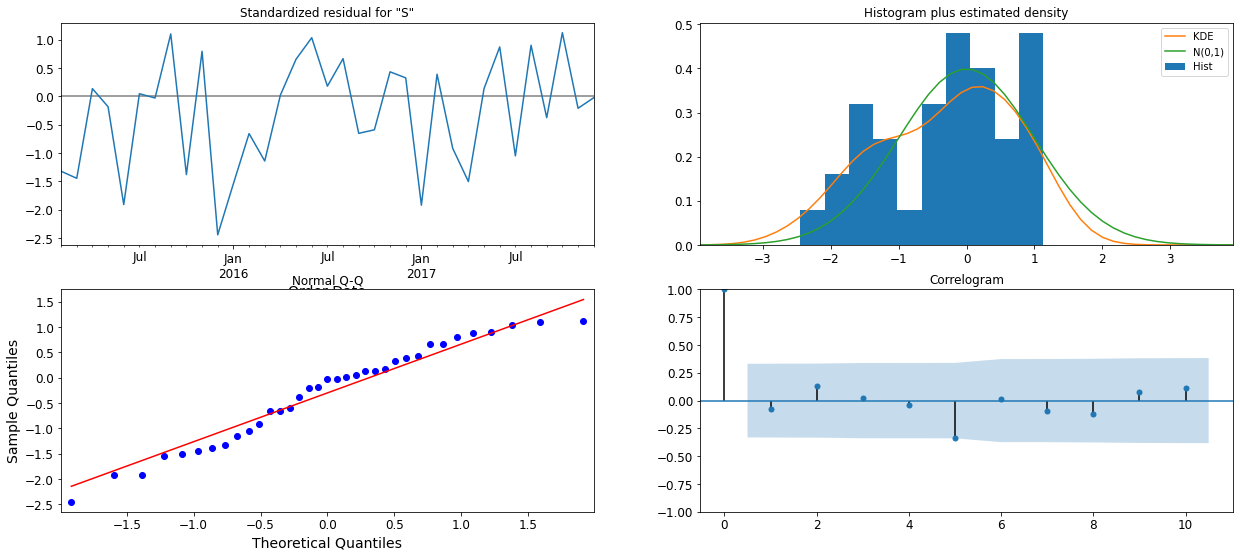

In [ ]:
#Plotting our Results
results.plot_diagnostics(figsize = (21,9))
plt.show()

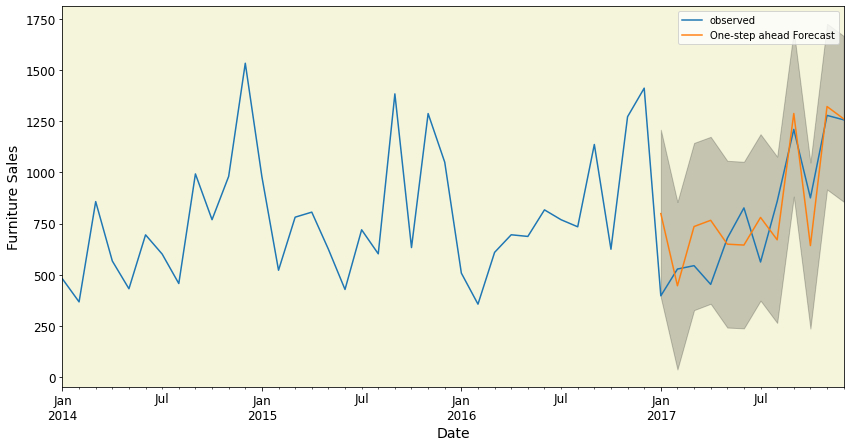

In [ ]:
#Now as we have our predicted values we can easily compare observed and predicted Value
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label="One-step ahead Forecast", alpha=7, figsize=(14,7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=.2)
ax.set_xlabel("Date")
ax.set_ylabel("Furniture Sales")
ax=plt.axes()
ax.set_facecolor('beige')
plt.legend()
plt.show()

In [ ]:
#Finding the mean square and root mean square error in our values
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print("The Mean Square Error is: ",mse)
print("The Root Mean Square Error is: ",np.sqrt(mse))

The Mean Square Error is:  39996.01051729486
The Root Mean Square Error is:  199.99002604453767


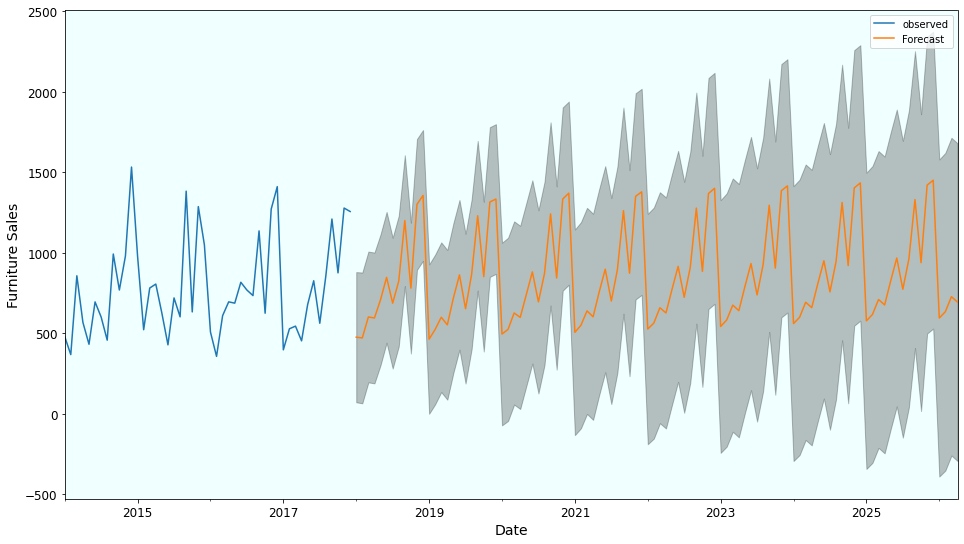

In [ ]:
#Plotting our predictions for future sales
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label = 'observed', figsize=(16,9))
pred_uc.predicted_mean.plot(ax=ax, label="Forecast")
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=.25)
ax.set_xlabel("Date")
ax.set_ylabel("Furniture Sales")
ax.set_facecolor('azure')
plt.legend()
plt.show()

##4 Comparing Sales

In [ ]:
#Creating two new sample dataset from our category
furniture = ss.loc[ss['Category'] == 'Furniture']
office = ss.loc[ss["Category"] == "Office Supplies"]
print(furniture.shape)
print(office.shape)

(2121, 21)
(6026, 21)


In [ ]:
#Creating unwanted columns list
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

#Dropping unwanted columns
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

#Sorting the values datewise in ascending order
furniture = furniture.sort_values("Order Date")
office = office.sort_values("Order Date")

furniture = furniture.groupby("Order Date")['Sales'].sum().reset_index() #Groupping the dataset by sales

#Resetting the index to Dates
furniture = furniture.set_index("Order Date")
office = office.set_index("Order Date")

#Resampling the data values
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

#Creating a dataframe for our new sorted values
furniture = pd.DataFrame({'Order Date': y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales':y_office.values})

#Creating a dataset with values of sales of furniture and office supplies to get comparison values
store = furniture.merge(office, how = 'inner', on = 'Order Date') #Using Inner Join to get same number of values
store.rename(columns = {'Sales_x': 'furniture_sales', 'Sales_y': "office_sales"}, inplace=True) #renaming the new columns
store.head() #printing top 5 rows to verify

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,97.021600
1,2014-02-01,367.931600,34.571742
2,2014-03-01,857.291529,84.371363
3,2014-04-01,567.488357,134.398482
4,2014-05-01,432.049188,100.501746


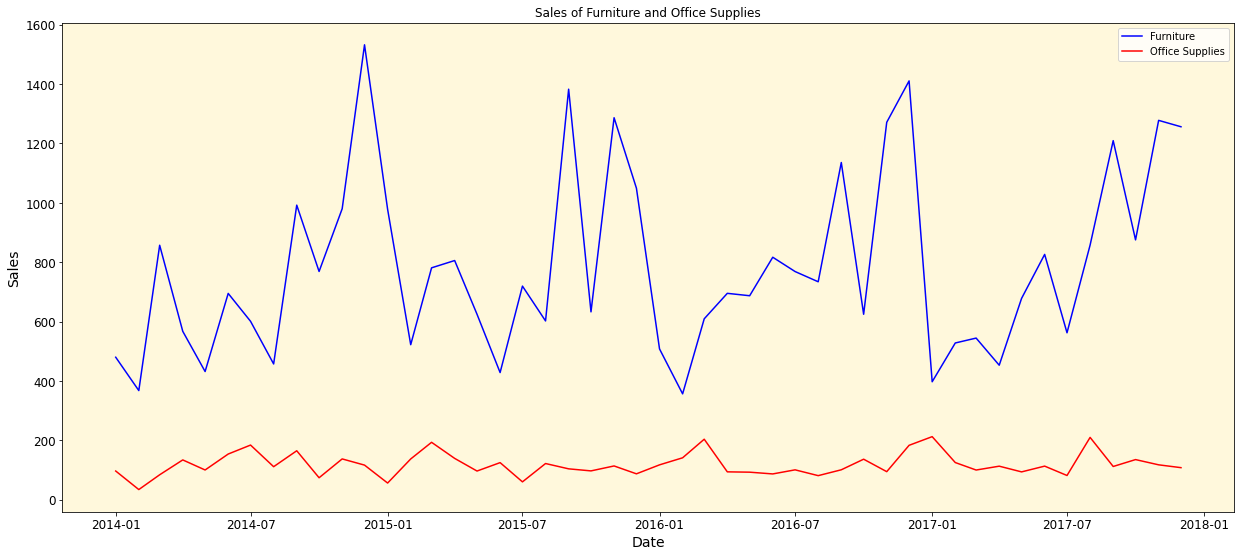

In [ ]:
#Plotting our comparison Graph
plt.figure(figsize=(21,9))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'Furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'Office Supplies')
plt.xlabel('Date')
plt.ylabel("Sales")
plt.title("Sales of Furniture and Office Supplies")
ax=plt.axes()
ax.set_facecolor('cornsilk')
plt.legend()
plt.show()

##5 Using Prophet to see our prediction values

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#Creating prophets for our already designed columns with 95% hypothesis
furniture = furniture.rename(columns = {'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width = 0.95)
furniture_model.fit(furniture)

office = office.rename(columns = {'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width = 0.95)
office_model.fit(office)

#Creating a forecasting Dataset for prediction
furniture_forecast = furniture_model.make_future_dataframe(periods = 36, freq = 'MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods = 36, freq = 'MS')
office_forecast = office_model.predict(office_forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjq8vg8cx/mh28npx0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjq8vg8cx/n8xe1bk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81190', 'data', 'file=/tmp/tmpjq8vg8cx/mh28npx0.json', 'init=/tmp/tmpjq8vg8cx/n8xe1bk1.json', 'output', 'file=/tmp/tmpjq8vg8cx/prophet_model5_ah_56f/prophet_model-20221121072355.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

<Figure size 1512x648 with 0 Axes>

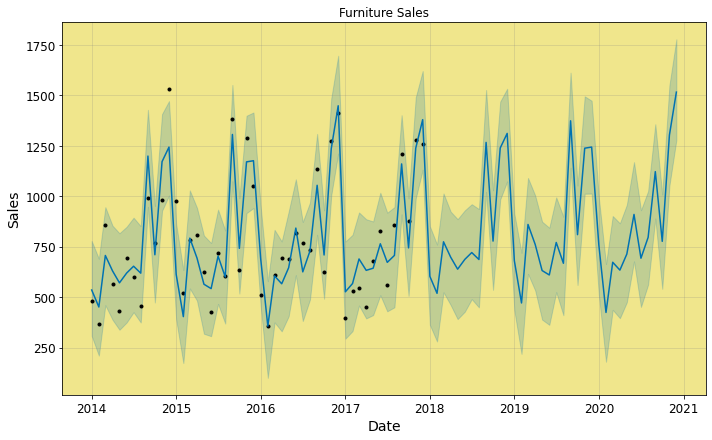

In [ ]:
#Plotting our Furniture sales prediction
plt.figure(figsize = (21,9))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title("Furniture Sales")
ax=plt.axes()
ax.set_facecolor('khaki')
plt.show()

<Figure size 1512x648 with 0 Axes>

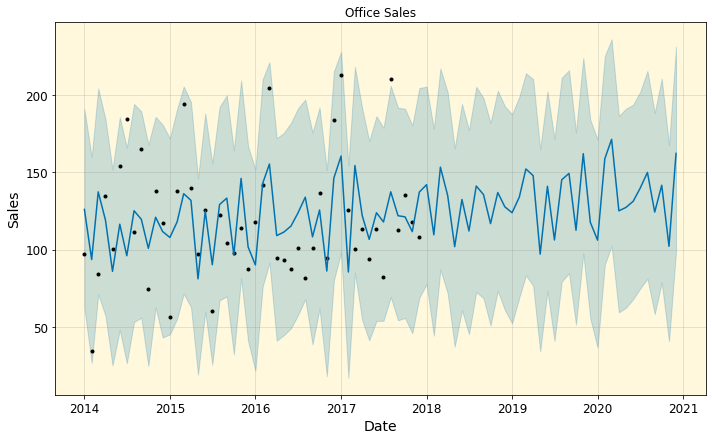

In [ ]:
#Plotting our Office Supplies Sale Predictions
plt.figure(figsize = (21,9))
office_model.plot(office_forecast, xlabel = "Date", ylabel="Sales")
plt.title("Office Sales")
ax=plt.axes()
ax.set_facecolor('cornsilk')
plt.show()